In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest


In [2]:
marketingeventos = pd.read_csv('datasets/ab_project_marketing_events_us.csv')
finaleventos = pd.read_csv('datasets/final_ab_events_upd_us.csv')
novosusuarios = pd.read_csv('datasets/final_ab_new_users_upd_us.csv')
participantes = pd.read_csv('datasets/final_ab_participants_upd_us.csv')


In [3]:
# Renomear colunas para português
marketingeventos = marketingeventos.rename(columns={
    'name': 'nome_evento',
    'regions': 'regioes',
    'start_dt': 'data_inicio',
    'finish_dt': 'data_fim'
})

# Converter datas para datetime
marketingeventos['data_inicio'] = pd.to_datetime(marketingeventos['data_inicio'])
marketingeventos['data_fim'] = pd.to_datetime(marketingeventos['data_fim'])

# Visualizar estrutura após ajustes
marketingeventos.info()
marketingeventos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   nome_evento  14 non-null     object        
 1   regioes      14 non-null     object        
 2   data_inicio  14 non-null     datetime64[ns]
 3   data_fim     14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes


,nome_evento,regioes,data_inicio,data_fim
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
finaleventos = finaleventos.rename(columns={
    'user_id': 'id_usuario',
    'event_dt': 'data_evento',
    'event_name': 'nome_evento',
    'details': 'detalhes'
})

finaleventos['data_evento'] = pd.to_datetime(finaleventos['data_evento'])

finaleventos.info()
finaleventos.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id_usuario   423761 non-null  object        
 1   data_evento  423761 non-null  datetime64[ns]
 2   nome_evento  423761 non-null  object        
 3   detalhes     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


,id_usuario,data_evento,nome_evento,detalhes
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


A coluna "detalhes" contem muitos valores ausentes, porém não sera necessario a sua remoção a menos que decidimos fazer uma analise de compras.

In [5]:
novosusuarios = novosusuarios.rename(columns={
    'user_id': 'id_usuario',
    'first_date': 'data_primeiro_acesso',
    'region': 'regiao',
    'device': 'dispositivo'
})

novosusuarios['data_primeiro_acesso'] = pd.to_datetime(novosusuarios['data_primeiro_acesso'])

novosusuarios.info()
novosusuarios.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_usuario            58703 non-null  object        
 1   data_primeiro_acesso  58703 non-null  datetime64[ns]
 2   regiao                58703 non-null  object        
 3   dispositivo           58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


,id_usuario,data_primeiro_acesso,regiao,dispositivo
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
participantes = participantes.rename(columns={
    'user_id': 'id_usuario',
    'group': 'grupo',
    'ab_test': 'teste_ab'
})

participantes.info()
participantes.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_usuario  14525 non-null  object
 1   grupo       14525 non-null  object
 2   teste_ab    14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


,id_usuario,grupo,teste_ab
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


##  Preparação dos Dados

Realizamos o pré-processamento com todos os DataFrames fornecidos, garantindo que estivessem prontos para as análises exploratórias e testes estatísticos subsequentes. Os principais ajustes incluíram:

- **Conversão de colunas de data** para o tipo `datetime`, o que permite manipulações temporais corretas (filtragem por período, cálculo de intervalo entre datas etc.).
- **Renomeação das colunas para o português**, visando padronização e clareza durante o desenvolvimento do projeto. 
- **Verificação de valores ausentes e duplicados**, assegurando a integridade das amostras.



## Analise Exploratoria

In [7]:
usuarios_pagina_produto = finaleventos[finaleventos['nome_evento'] == 'product_page']['id_usuario'].nunique()
usuarios_carrinho = finaleventos[finaleventos['nome_evento'] == 'product_cart']['id_usuario'].nunique()
usuarios_compra = finaleventos[finaleventos['nome_evento'] == 'purchase']['id_usuario'].nunique()

usuarios_totais = finaleventos['id_usuario'].nunique()

taxa_pagina_produto = usuarios_pagina_produto / usuarios_totais
taxa_carrinho = usuarios_carrinho / usuarios_totais
taxa_compra = usuarios_compra / usuarios_totais

print(f"Usuários únicos no experimento: {usuarios_totais}")
print(f"Usuários que visualizaram página de produto: {usuarios_pagina_produto} ({taxa_pagina_produto:.2%})")
print(f"Usuários que adicionaram ao carrinho: {usuarios_carrinho} ({taxa_carrinho:.2%})")
print(f"Usuários que realizaram compra: {usuarios_compra} ({taxa_compra:.2%})")


Usuários únicos no experimento: 58703
Usuários que visualizaram página de produto: 38929 (66.32%)
Usuários que adicionaram ao carrinho: 19284 (32.85%)
Usuários que realizaram compra: 19568 (33.33%)


Conversão por Etapa do Funil

A análise da conversão dos usuários ao longo das etapas do funil `product_page → product_cart → purchase` mostra o seguinte:

- **66,32%** dos usuários visualizaram ao menos uma página de produto.
- **32,85%** adicionaram produtos ao carrinho.
- **33,33%** finalizaram uma compra.

O número de compradores é ligeiramente maior do que os que adicionaram ao carrinho, o que pode indicar que parte dos usuários realizou a compra de forma direta (sem passar pelo evento intermediário).



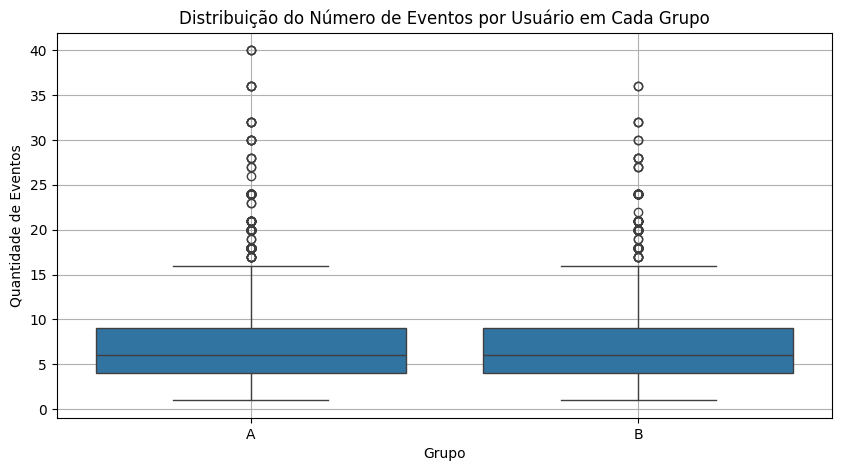

In [8]:
eventos_com_grupo = finaleventos.merge(participantes, on='id_usuario')

eventos_por_usuario = eventos_com_grupo.groupby(['id_usuario', 'grupo']).size().reset_index(name='quantidade_eventos')

estatisticas_eventos = eventos_por_usuario.groupby('grupo')['quantidade_eventos'].describe()

plt.figure(figsize=(10, 5))
sns.boxplot(data=eventos_por_usuario, x='grupo', y='quantidade_eventos')
plt.title('Distribuição do Número de Eventos por Usuário em Cada Grupo')
plt.xlabel('Grupo')
plt.ylabel('Quantidade de Eventos')
plt.grid(True)
plt.show()


 Distribuição do Número de Eventos por Usuário em Cada Grupo

O boxplot acima mostra que a **quantidade de eventos por usuário** está distribuída de forma muito semelhante entre os grupos **A (controle)** e **B (teste)**.

- A mediana e os quartis são praticamente iguais entre os grupos.
- Ambos os grupos apresentam a mesma tendência de distribuição e número de outliers.
- Isso indica que **o comportamento de navegação geral foi equilibrado entre as amostras**, o que reforça a validade do experimento e reduz risco de viés relacionado à exposição desigual.


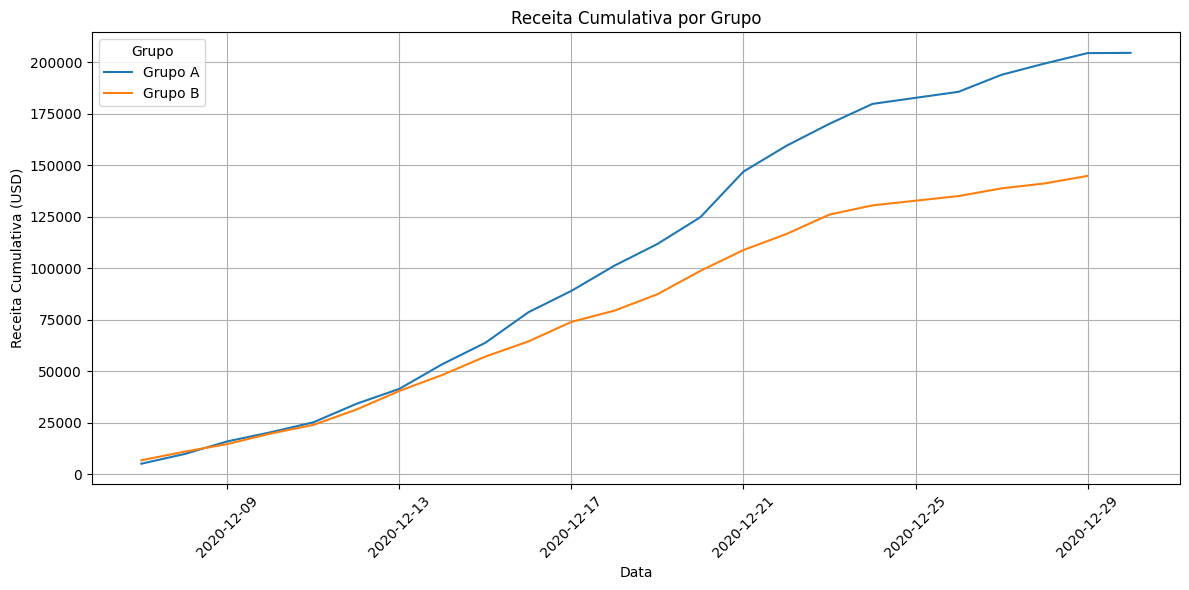

In [9]:
# Filtrar apenas eventos de compra e unir com os grupos
compras = finaleventos[finaleventos['nome_evento'] == 'purchase']
compras_com_grupo = compras.merge(participantes, on='id_usuario')

# Criar coluna apenas com a data (sem hora)
compras_com_grupo['data'] = compras_com_grupo['data_evento'].dt.date

# Agrupar por data e grupo, somando receita (detalhes)
receita_diaria = compras_com_grupo.groupby(['data', 'grupo'])['detalhes'].sum().reset_index()

# Calcular receita cumulativa por grupo
receita_diaria['receita_cumulativa'] = receita_diaria.groupby('grupo')['detalhes'].cumsum()

plt.figure(figsize=(12, 6))
for grupo, dados in receita_diaria.groupby('grupo'):
    plt.plot(dados['data'], dados['receita_cumulativa'], label=f'Grupo {grupo}')

plt.title('Receita Cumulativa por Grupo')
plt.xlabel('Data')
plt.ylabel('Receita Cumulativa (USD)')
plt.legend(title='Grupo')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Verificação de Participação no Teste A/B

Ao comparar os usuários que realizaram eventos (`finaleventos`) com os participantes oficialmente registrados no experimento (`participantes`), observamos o seguinte:

- **58.703** usuários realizaram eventos no período analisado.
- Apenas **13.638** estão identificados como participantes do teste A/B.
- Isso significa que **45.065 usuários (~77%)** com eventos **não pertencem oficialmente ao experimento**.


          data  quantidade_eventos
0   2020-12-07               11385
1   2020-12-08               12547
2   2020-12-09               12122
3   2020-12-10               14077
4   2020-12-11               13864
5   2020-12-12               17634
6   2020-12-13               20985
7   2020-12-14               26184
8   2020-12-15               23469
9   2020-12-16               20909
10  2020-12-17               21751
11  2020-12-18               22871
12  2020-12-19               24273
13  2020-12-20               26425
14  2020-12-21               32559
15  2020-12-22               29472
16  2020-12-23               26108
17  2020-12-24               19399
18  2020-12-26               14058
19  2020-12-27               12420
20  2020-12-28               11014
21  2020-12-29               10146
22  2020-12-30                  89


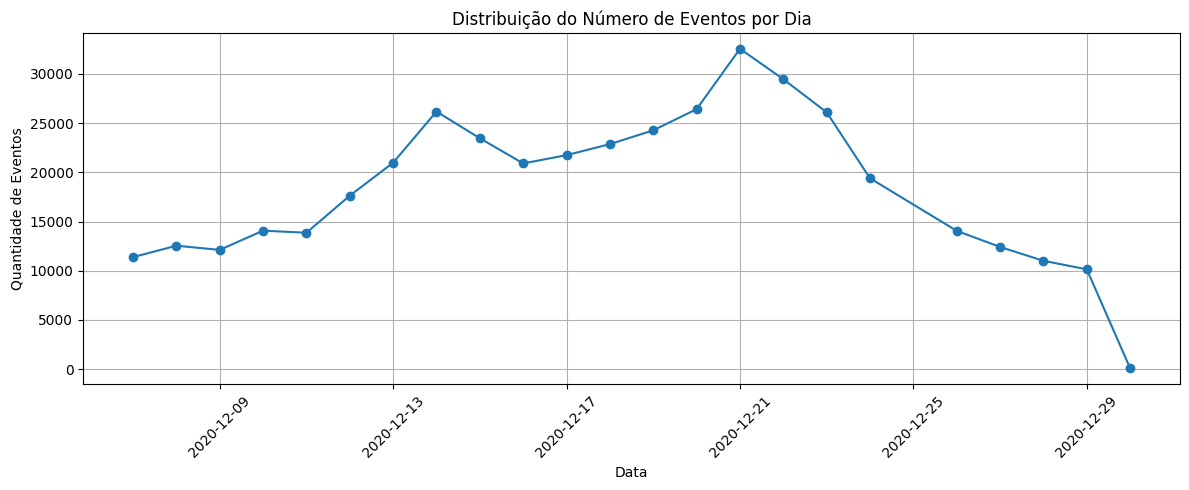

In [10]:
finaleventos['data'] = finaleventos['data_evento'].dt.date
eventos_por_dia = finaleventos.groupby('data').size().reset_index(name='quantidade_eventos')

print(eventos_por_dia)

plt.figure(figsize=(12, 5))
plt.plot(eventos_por_dia['data'], eventos_por_dia['quantidade_eventos'], marker='o')
plt.title('Distribuição do Número de Eventos por Dia')
plt.xlabel('Data')
plt.ylabel('Quantidade de Eventos')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Distribuição Diária de Eventos

A análise temporal mostra a evolução da atividade dos usuários durante o experimento. A distribuição diária revela:

- Um crescimento gradual de eventos entre os dias **07/12 e 21/12**, com um **pico absoluto no dia 21/12** (32.559 eventos), que coincide com o **último dia de inclusão de novos usuários no experimento**.
- Após o dia 21/12, a atividade começa a diminuir progressivamente, com forte queda após o dia 24/12 — provavelmente influenciada pelo período de festas de fim de ano.
- O último dia, 30/12, apresenta atividade quase nula (apenas 89 eventos), indicando fim do ciclo de engajamento.



In [13]:
grupo_a = participantes[participantes['grupo'] == 'A']['id_usuario']
grupo_b = participantes[participantes['grupo'] == 'B']['id_usuario']

usuarios_em_ambos = set(grupo_a).intersection(set(grupo_b))

total_unicos = participantes['id_usuario'].nunique()
percentual_em_ambos = len(usuarios_em_ambos) / total_unicos * 100

print(f"Usuários presentes em ambos os grupos: {len(usuarios_em_ambos)}")
print(f"Percentual de sobreposição: {percentual_em_ambos:.2f}%")

Usuários presentes em ambos os grupos: 441
Percentual de sobreposição: 3.23%


---

Particularidades dos Dados a Considerar Antes do Teste A/B

Antes de iniciar os testes estatísticos de comparação entre os grupos, algumas características críticas dos dados precisam ser levadas em conta:

 1. Presença de usuários fora do experimento
- Dos **58.703 usuários** que realizaram eventos, apenas **13.638** estão oficialmente vinculados a grupos A ou B.
- Ou seja, **~77% dos usuários com eventos não pertencem ao teste A/B** e **devem ser excluídos** da análise para evitar viés.

 2. Distribuição equilibrada entre grupos
- A **quantidade de eventos por usuário** está bem distribuída entre os grupos A e B, o que confirma que a randomização foi eficaz. Isso fortalece a validade do experimento.

 3. Efeito de datas e sazonalidade
- Há um **pico de atividade em 21/12**, último dia de inclusão de novos usuários no teste.
- Após o dia 24/12, há **queda acentuada de atividade**, coincidindo com o período de festas.
- Essas flutuações podem influenciar as conversões, especialmente em grupos que entraram mais tarde.

 4. Participantes com eventos fora da janela de 14 dias
- O experimento prevê análise **até 14 dias após o cadastro**. Eventos que ocorrem fora dessa janela devem ser removidos ou ignorados na comparação de desempenho.

 5. Anomalia no funil
- A conversão final (`purchase`) está **ligeiramente maior que a do carrinho (`product_cart`)**, o que sugere que alguns usuários podem estar realizando compras sem adicionar ao carrinho.
- Esse comportamento deve ser considerado ao interpretar os resultados.

---



6. Sobreposição de usuários entre grupos

Foi identificado que **441 usuários estão presentes em ambos os grupos A e B**, o que representa **3,23% dos participantes únicos**. Isso **viola a premissa de independência estatística** entre os grupos — um requisito essencial para a robustez dos testes de hipótese aplicados.

Essa sobreposição pode comprometer parcialmente a validade dos resultados, pois os mesmos usuários estão contribuindo para as métricas de conversão dos dois grupos. O ideal seria **remover esses casos da base** antes de executar qualquer comparação entre os grupos.

Essa é uma limitação relevante e deve ser considerada na interpretação final dos resultados estatísticos.


## Formulação das Hipóteses para o Teste A/B

Para cada etapa do funil (`product_page`, `product_cart`, `purchase`), definimos as hipóteses a serem testadas estatisticamente:

 Hipóteses Gerais

- **Hipótese Nula (H₀):** Não há diferença significativa na taxa de conversão entre os grupos A e B.
- **Hipótese Alternativa (H₁):** Há diferença significativa na taxa de conversão entre os grupos A e B.

Como o objetivo do teste é verificar se o novo sistema de recomendação (grupo B) melhora a conversão, estamos especialmente atentos a aumentos significativos nas taxas do grupo B. No entanto, a formulação acima é **bilateral**, ou seja, o teste detecta qualquer diferença (positiva ou negativa).

O nível de significância adotado é **α = 0.05**. Caso o valor-p seja menor que esse limiar, rejeitamos H₀ e aceitamos que há diferença estatística entre os grupos.

Em seguida, aplicamos o z-teste para proporções nas três etapas do funil.


In [14]:
finaleventos_com_grupo = finaleventos.merge(participantes, on='id_usuario')

# Criar função para calcular z-teste por etapa do funil
def testar_proporcao(evento):
    dados = finaleventos_com_grupo[finaleventos_com_grupo['nome_evento'] == evento]
    contagem = dados.groupby('grupo')['id_usuario'].nunique()
    
    total_a = participantes[participantes['grupo'] == 'A']['id_usuario'].nunique()
    total_b = participantes[participantes['grupo'] == 'B']['id_usuario'].nunique()

    # Sucessos = número de usuários únicos que realizaram o evento em cada grupo
    sucessos = [contagem.get('A', 0), contagem.get('B', 0)]
    totais = [total_a, total_b]
    
    stat, p_valor = proportions_ztest(sucessos, totais)
    
    print(f"Evento: {evento}")
    print(f"Grupo A: {sucessos[0]}/{totais[0]} ({sucessos[0]/totais[0]:.2%})")
    print(f"Grupo B: {sucessos[1]}/{totais[1]} ({sucessos[1]/totais[1]:.2%})")
    print(f"p-valor: {p_valor:.4f}")
    print("Resultado:", "Diferença significativa" if p_valor < 0.05 else "Não significativa")
    print("-" * 40)

# Avaliar as 3 etapas do funil
testar_proporcao('product_page')
testar_proporcao('product_cart')
testar_proporcao('purchase')


Evento: product_page
Grupo A: 5208/7874 (66.14%)
Grupo B: 3986/6205 (64.24%)
p-valor: 0.0185
Resultado: Diferença significativa
----------------------------------------
Evento: product_cart
Grupo A: 2483/7874 (31.53%)
Grupo B: 2037/6205 (32.83%)
p-valor: 0.1025
Resultado: Não significativa
----------------------------------------
Evento: purchase
Grupo A: 2682/7874 (34.06%)
Grupo B: 2008/6205 (32.36%)
p-valor: 0.0336
Resultado: Diferença significativa
----------------------------------------


 Avaliação dos Resultados do Teste A/B

Utilizando o **z-teste para comparação de proporções**, avaliamos o desempenho dos grupos A (controle) e B (teste com novo sistema de recomendação) em cada etapa do funil. Os resultados foram:

 1. Visualização de Página de Produto (`product_page`)
- **Grupo A**: 66,14%  
- **Grupo B**: 64,24%  
- **p-valor = 0.0185 → Diferença estatisticamente significativa**
- **Observação**: o grupo controle teve desempenho superior — **contrário ao esperado**.

2. Adição ao Carrinho (`product_cart`)
- **Grupo A**: 31,53%  
- **Grupo B**: 32,83%  
- **p-valor = 0.1025 → Diferença não significativa**
- **Observação**: desempenho similar, **sem evidência de impacto da nova recomendação**.

 3. Compra Realizada (`purchase`)
- **Grupo A**: 34,06%  
- **Grupo B**: 32,36%  
- **p-valor = 0.0336 → Diferença estatisticamente significativa**
- **Observação**: novamente, o **grupo controle converteu melhor**.

---


Conclusões Finais da AED

Durante a etapa de AED, identificamos os seguintes pontos-chave:

- O funil de conversão apresentou comportamento esperado, com:
  - 66% dos usuários visualizando páginas de produto;
  - 32% adicionando itens ao carrinho;
  - 33% realizando compras.
- A distribuição de eventos por usuário está equilibrada entre os grupos A e B, indicando uma boa randomização.
- A atividade diária dos usuários aumentou até o dia 21/12 (último dia de inclusão) e caiu significativamente após o Natal, sinalizando efeito sazonal no engajamento.
- Apenas 23% dos usuários com eventos fazem parte do experimento, o que exigiu filtragem para análises válidas.
- A ordem do funil mostra uma anomalia: mais compras que adições ao carrinho — o que pode indicar bypass de etapas no fluxo do usuário.

Essas análises ajudaram a preparar e qualificar os dados para o teste estatístico com segurança.

---

Resultado do Teste A/B

Realizamos testes z para proporções em cada etapa do funil. As conclusões foram:

- **`product_page`**: Grupo A teve performance significativamente superior (p = 0.0185)
- **`product_cart`**: Não houve diferença significativa (p = 0.1025)
- **`purchase`**: Grupo A novamente teve melhor resultado (p = 0.0336)

A proposta inicial do experimento era que o novo sistema de recomendação (grupo B) aumentasse a conversão em pelo menos 10% em cada etapa. Isso **não aconteceu**. Na verdade, o grupo B teve desempenho **pior em duas das três etapas**, com significância estatística.

---

Conclusão Geral

O novo sistema de recomendação **não demonstrou impacto positivo** no funil de conversão. Com base nas evidências estatísticas, **não recomendamos sua implementação** neste formato atual. Sugerimos uma revisão da lógica do sistema e novos testes controlados em um cenário mais neutro (sem sazonalidade).

